In [43]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io.wavfile
from scipy.fftpack import dct


Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']
sample_rate =  44100


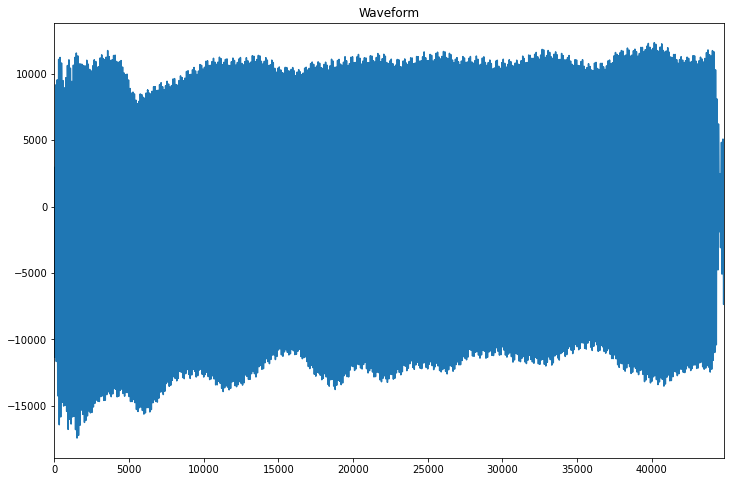

In [44]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))    

notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

#test_file = tf.io.read_file(filenames[0])
#test_audio, _ = tf.audio.decode_wav(contents=test_file)
#signal = test_audio
sample_rate, signal = scipy.io.wavfile.read(filenames[0])
print('sample_rate = ', sample_rate)

fig, ax = plt.subplots(1, figsize=(12, 8))
timescale = np.arange(signal.shape[0])
ax.plot(timescale, signal)
ax.set_title('Waveform')
ax.set_xlim([0, signal.shape[0]])
plt.show()

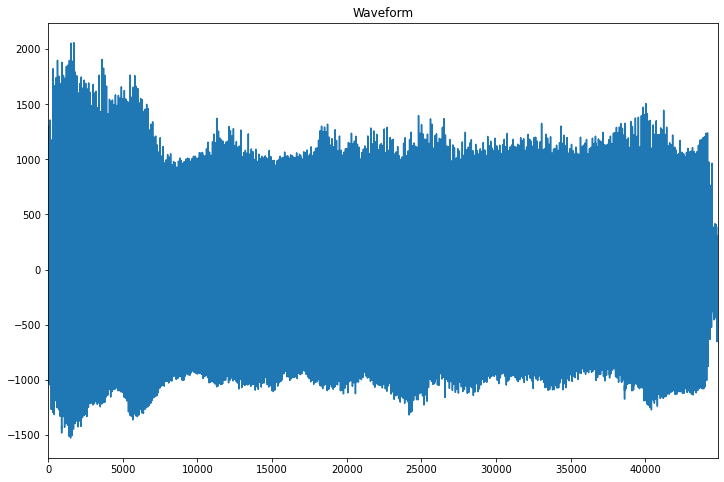

In [45]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

fig, ax = plt.subplots(1, figsize=(12, 8))
timescale = np.arange(emphasized_signal.shape[0])
ax.plot(timescale, emphasized_signal)
ax.set_title('Waveform')
ax.set_xlim([0, emphasized_signal.shape[0]])
plt.show()

## Выделение фреймов
После предыскажения нам нужно разбить сигнал на короткие временные рамки. Обоснование этого шага заключается в том, что частоты сигнала меняются со временем, поэтому в большинстве случаев нет смысла выполнять преобразование Фурье для всего сигнала, поскольку со временем мы потеряли бы частотные контуры сигнала. Чтобы избежать этого, мы можем с уверенностью предположить, что частоты в сигнале остаются постоянными в течение очень короткого периода времени. Следовательно, выполняя преобразование Фурье для этого короткого кадра, мы можем получить хорошую аппроксимацию частотных контуров сигнала путем объединения соседних кадров. Типичные размеры кадров при обработке речи находятся в диапазоне от 20 мс до 40 мс с 50% (+/-10%) перекрытием между последовательными кадрами. Мы рассмотрим размер кадра, равный 2048 отсчетов (примерно 46 мс при частоте дискретизации равной 44.1 кГц), и шаг кадра, равный половине размера кадра.

## Применение оконной функции
После разделения сигнала на кадры мы применяем оконную функцию, такую как окно Хэмминга, к каждому кадру. Окно Хэмминга имеет следующий вид: $$w(n) = 0.54-0.46 \bullet \cos(2\pi nN-1),\quad\quad\quad (1)$$
где $0\leq n \leq N-1$, $N$ - длина окна.  

Есть несколько причин, по которым нам необходимо применять оконную функцию к кадрам, в частности, чтобы противодействовать предположению, сделанному БПФ, о том, что данные бесконечны, и уменьшить спектральную утечку.

In [46]:
frame_length = 2048
frame_step = frame_length/2
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # чтобы убедиться, что у нас 
# есть хотя бы 1 кадр.
 
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # чтобы убедиться, что все кадры имеют одинаковое количество сэмплов 
# без усечения сэмплов исходного сигнала.
 
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [47]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))

## Преобразование Фурье и Спектр мощности
Теперь мы можем выполнить $N$-точечное БПФ для каждого кадра, чтобы рассчитать частотный спектр, который также называется кратковременным преобразованием Фурье (STFT), где $N$ обычно равно 256 или 512 (рассмотрим $N$ = 2048 по длине окна); а затем вычислить спектр мощности (периодограмму), используя следующее уравнение: $$P = \frac{|FFT(x_i)|^{2}}{N},\quad\quad\quad(2)$$
где $x_i$ - $i$-тый кадр сигнала $x$.

После вычисления мощности спектра сравним полученные величины с мощностью сигнала. По равенству Персеваля они должны примерно совпадать. Для сравнения разобьем сигнал на фреймы в соответствии с делением на фреймы при получении спектра.

In [48]:
NFFT = 2048
waveform = tf.cast(signal, tf.float32)
mag_frames = tf.signal.stft(waveform, frame_length=NFFT, frame_step=int(NFFT/2),pad_end=True)
mag_frames = tf.abs(mag_frames)
norms1 = np.linalg.norm(mag_frames, axis=1)

norms2 = []
for k in range(int(np.ceil(len(waveform)/NFFT*2))):
    norms2.append(np.linalg.norm(waveform[k*int(NFFT/2):k*int(NFFT/2)+NFFT]))

res = []    
for k in range(len(norms2)):
    res.append(norms1[k]/norms2[k])
print(res)    

[19.931862, 19.770632, 19.47042, 19.538174, 19.477547, 19.898846, 19.487503, 19.383013, 19.637823, 19.594042, 19.715254, 19.587515, 19.639168, 19.653093, 19.478058, 19.352854, 19.660177, 19.789091, 19.661003, 19.389654, 19.592203, 19.764603, 19.560717, 19.51581, 19.570593, 19.770714, 19.492144, 19.593292, 19.488108, 19.667154, 19.625563, 19.663143, 19.569435, 19.564434, 19.590153, 19.417604, 19.665827, 19.563683, 19.708244, 19.68383, 19.508467, 19.551567, 21.768492, 10.435148]


Как видно из результатов, мощность спектра примерно в 19 раз больше мощности сигнала в каждом фрейме, за исключением двух последних.

In [50]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # спектр мощности

## Банки фильтров
Последним шагом к вычислению банков фильтров является применение треугольных фильтров, обычно 40 фильтров, по шкале Мела, к спектру мощности для выделения частотных диапазонов. Шкала Мела связывает воспринимаемую частоту или высоту звука чистого тона с его фактической измеренной частотой. Она направлена на то, чтобы имитировать нелинейное восприятие звука человеческим ухом, будучи более различимой на более низких частотах и менее различимой на более высоких частотах. Мы можем конвертировать между Герцами (f) и Mel (m), используя следующие уравнения:
$$m = 2595 \log_{10} \left(1+\frac{f}{700}\right), \quad\quad\quad(3)$$
$$f = 700 \left(10^{\frac{m}{2595}}-1\right).\quad\quad\quad(4)$$

Каждый фильтр в банке фильтров имеет треугольную форму с откликом 1 на центральной частоте и линейно уменьшается к 0, пока не достигнет центральных частот двух соседних фильтров, где отклик равен 0. Это можно смоделировать с помощью следующего уравнения: 
$$
H_m (k)=
\begin{cases}
   0, &\text{ $k<f(m-1)$},\\
   \frac{k-f(m-1)}{f(m)-f(m-1)}, &\text{ $f(m-1) \leq k < f(m)$},\\
   \frac{f(m+1)-k}{f(m+1)-f(m)}, &\text{ $f(m) \leq k \leq f(m+1)$},\\
   0, &\text{ $k > f(m+1)$}.
 \end{cases}
\quad\quad\quad(5)
$$
$f$ - список из $M+2$ меловых частот, $M$ - количество фильтров. 

In [51]:
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Численная стабильность 
# (np.finfo(float).eps - машинный ноль)
mfcc = np.log(filter_banks)  # Логарифмические энергии набора фильтров
mfcc.shape

(44, 40)

C:\Users\belas\AppData\Local\Temp/ipykernel_8568/4233451198.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram)


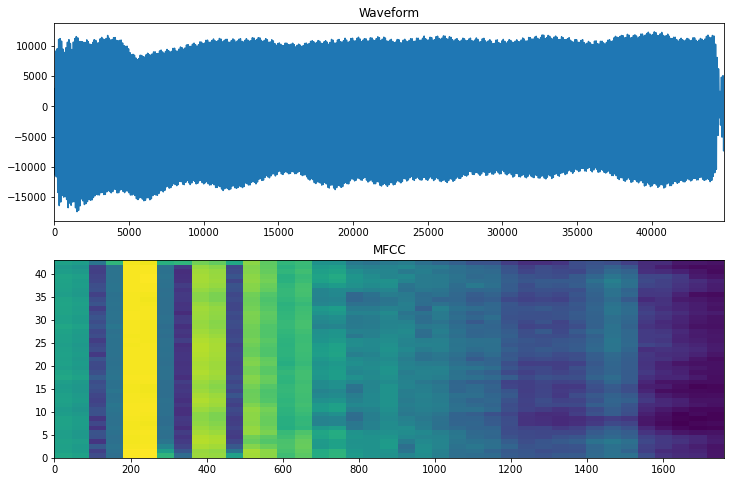

In [52]:
def plot_spectrogram(spectrogram, ax):
    # Преобразуем в частоты для логарифмической шкалы и транспонируем так, чтобы время
    # было представлено на оси x (столбцы). Эпсилон добавляется, чтобы избежать нуля.
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, waveform.shape[0]])
plot_spectrogram(mfcc, axes[1])
axes[1].set_title('MFCC')
plt.show()
plt.show()